# User Data Analysis

In [1]:
#packages
import pandas as pd
import numpy as np
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

## Rigid body position heatmap

In [68]:
user_data = pd.read_csv('./FinalDatasets/users/pedro.txt')
start_data = user_data.loc[user_data['start'].str.contains('globalstart')]# if not it assumes it is all data BE CAREFUL HERE
startTime = 0
if start_data.shape[0] > 0:
    startTime = float(start_data.values[0][0].split()[0])
    print(startTime)
mocap_data = user_data.loc[user_data['start'].str.contains('mocap')]
mocap_data = mocap_data.start.str.split(pat=' ',expand=True)
mocap_data = mocap_data[mocap_data[0].astype(float) > startTime]

limit = 2500
step = 200
heatsize = int(limit * 2 / step)
heatmap_x_y = np.zeros( (heatsize, heatsize) , dtype=np.int64)#2.5 meters, 2500 mm x 2500 mm
heatmap_x_z = np.zeros( (heatsize, heatsize) , dtype=np.int64)
for index, row in mocap_data.iterrows():
    x = float(row[2])
    y = float(row[3])
    z = float(row[4])
    if (x >= -limit) and (x <= limit) and (y >= -limit) and (y <= limit) and (z >= -limit) and (z <= limit):
        i = int((x + limit) / step)
        j = int((y + limit) / step)
        k = int((z + limit) / step)
        heatmap_x_y[j][i] += 1
        heatmap_x_z[k][i] += 1

# plt.figure()
#data = np.array([mocap_data[2].astype(float), mocap_data[3].astype(float)])
# print(data)
#plt.imshow(heatmap)
# plt.show()
#print(mocap_data[2].astype(float).values.tolist())
#1179898.380

#sns.heatmap(heatmap)

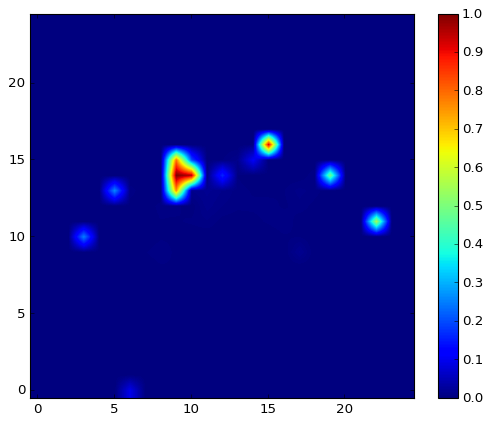

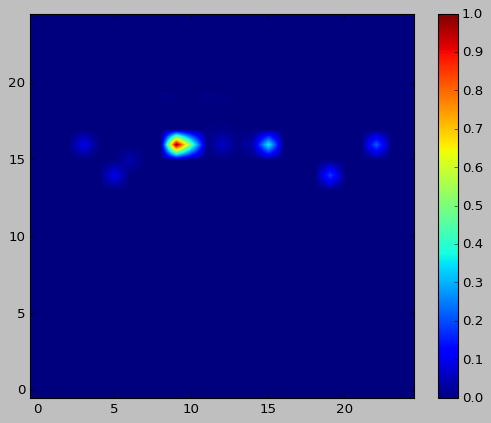

In [69]:

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
norm =  NormalizeData(heatmap_x_y)
plt.style.use('classic')
#plt.rcParams.update(plt.rcParamsDefault)
plt.imshow(NormalizeData(heatmap_x_y))
plt.gca().invert_yaxis()
plt.gcf().set_facecolor('white')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(NormalizeData(heatmap_x_z))
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.rcParams.update(plt.rcParamsDefault)